In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [ ]:
# read data
df = pd.read_csv('data.csv')

# Loading Keras Models

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('G6_yield_prediction_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,561
Trainable params: 1,561
Non-trainable params: 0
______________________________________________________

# Task 3: Decision making

### Main idea:
- use for loop to run through all scenarios of controlable inputs
- save each scenario's  ``total_cost`` and all relevant information to a daframe
- sort the resulting dataframe by ``total_cost`` in ascending order to find the optimal cost

### Cost function:
The ``total_cost`` for a given set of production inputs and demand level can be computed using the following formula:  

$ total_-cost = penalty_-cost + temperature_-cost + irrigation_-cost + area_-cost $

in which:

- $
penalty_-cost = 
\begin{cases}
1*(demand - production), & \text{if } production < demand\\
0 , &\text{if } production \ge demand
\end{cases}
$

- $ temperature_-cost = 3600* |t_\text{in} - t_\text{out}| $
- $ irrigation_-cost = irr_-volume * 0.021 \text{ (or 0.000021 if convert to liters)}$
- $ area_-cost = 20 * size $



## 3.1. Plot the relationships between ``yield`` and ``sun``, ``irrigation``, and ``temperature``

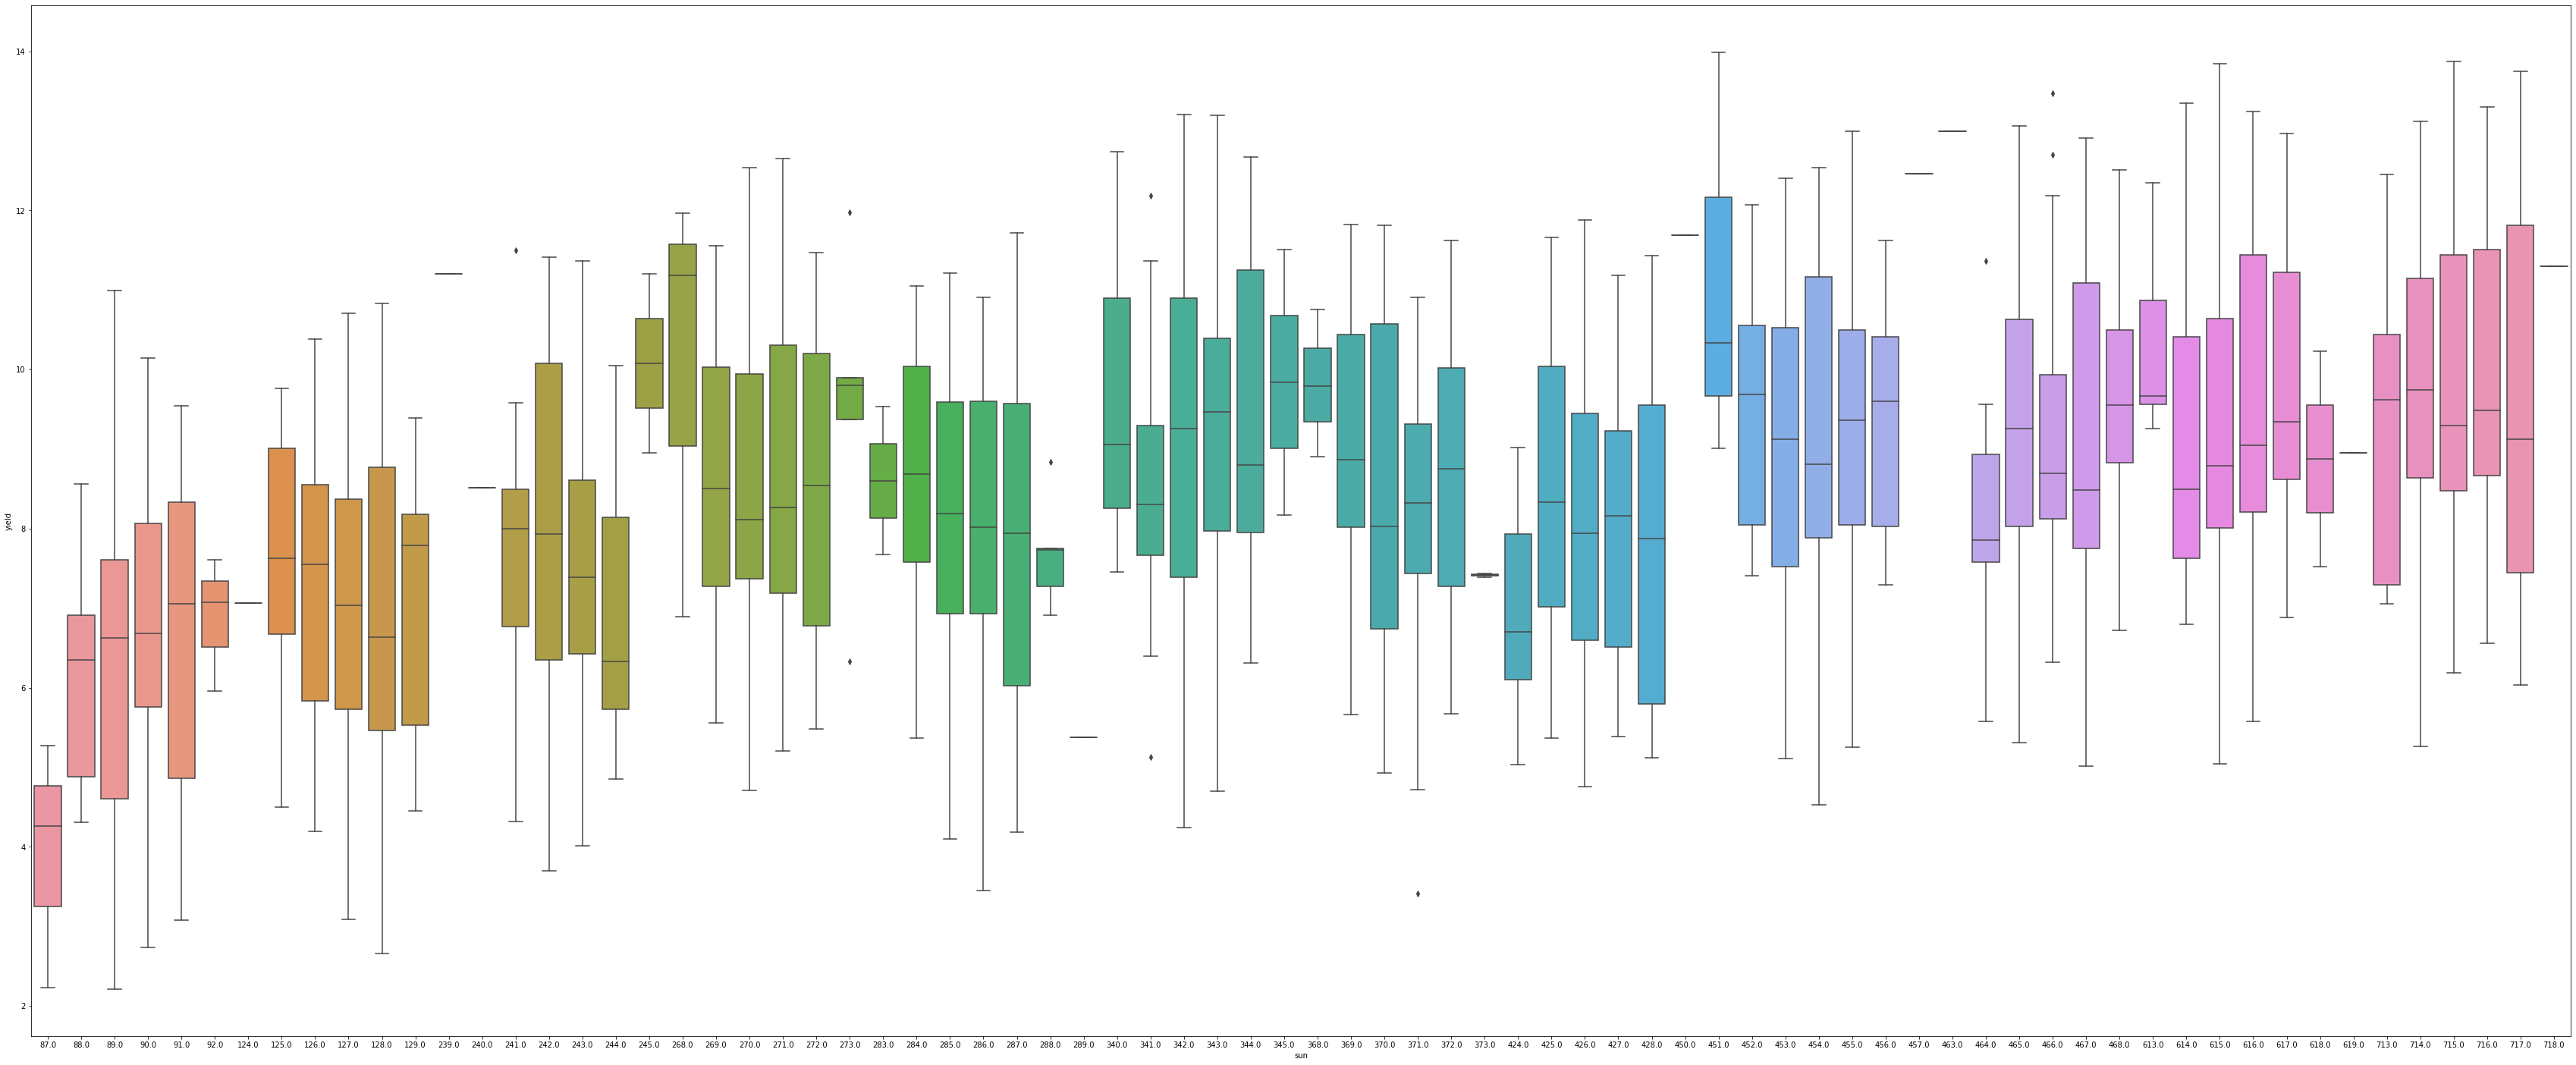

In [ ]:
# plot historical data to find the feasible range for sun factor 
fig, ax = plt.subplots()
fig.set_figheight(25)
fig.set_figwidth(60)
ax = sns.boxplot(x=np.round(df['sun']), y= df['yield'])
fig.savefig('Sun and yield box plot')

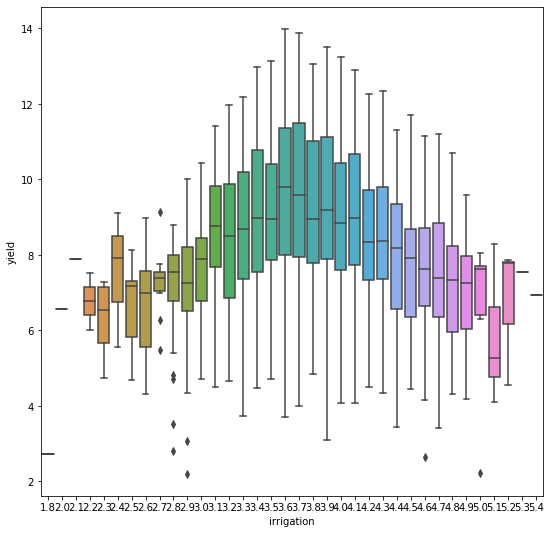

In [ ]:
# plot historical data to find the feasible range for irrigation factor 
fig, ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(9)
#data = sns.load_dataset('data.csv')
ax = sns.boxplot(x=np.round(df['irrigation'],1), y= df['yield'])
fig.savefig('Irrigation and yield box plot')

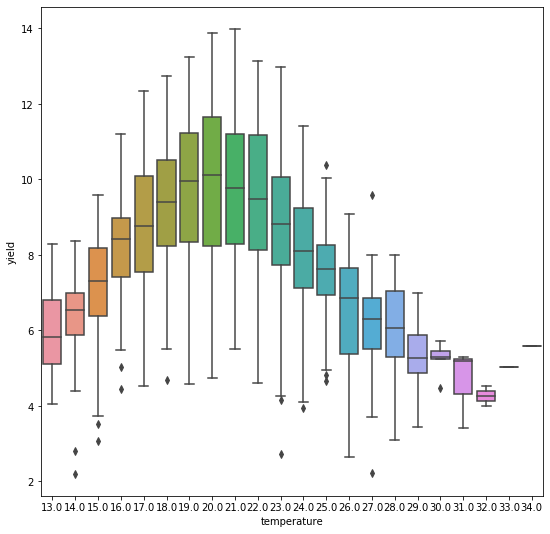

In [ ]:
# plot historical data to find the feasible range for temperature factor 
fig, ax = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(9)
#data = sns.load_dataset('data.csv')
ax = sns.boxplot(x=np.round(df['temperature']), y= df['yield'])
fig.savefig('temperature and yield box plot')

## 3.2. Find the minimum ``total_cost`` in each cycle
### Notice:
Each of the following cells in each cycle include over 40 million computations. As soon as you press 'run', please go get a tea/coffee while waiting for your computer to execute it.
## Cycle 2

In [ ]:
#create a input dataframe for yield prediction and a dataframe to keep track all scenarios
input_values = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6'])
keep_track_C2 = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6','area','predict_yield','production','penalty_cost','temperature_cost', 'irrigation_cost', 'area_cost', 'total_cost'])
counter = 0

# use for loop to run through all scenarios (pesticide = country in our model)
for area in range (1000, 51000, 1000):
    for pesticide in range (0, 2, 1):
        for irr_daily in np.arange (1.5, 6, 0.5):   #use numpy to loop with float
            for t_in in range (13, 35, 1):
                
                # predict yield in each scenario
                input_values.loc[1] = [pesticide, irr_daily, 278.5, float(t_in), 0, 1, 0, 0, 0, 0]
                predict_yield = model.predict(input_values)
                
                # compute the cost in each scenario 
                if predict_yield[0][0]*area < 300000:
                    penalty_cost = (300000-predict_yield[0][0]*area)
                else:
                    penalty_cost = 0
                temperature_cost = 3600*abs(t_in-15)
                irrigation_cost = 0.000021*60*irr_daily*area 
                area_cost = 20*area/6      #the cost is on yearly basis so we devide it by 6 for one cycle 
                total_cost = penalty_cost + temperature_cost + irrigation_cost + area_cost
                
                # keep track inputs and costs in all scenarios
                counter = counter + 1
                keep_track_C2.loc[counter] = [pesticide, irr_daily, 278.5, t_in, 0, 1, 0, 0, 0, 0, area, predict_yield[0][0], area*predict_yield[0][0], penalty_cost, temperature_cost, irrigation_cost, area_cost, total_cost]

# sort the scenarios by the descending order of total_cost                
keep_track_C2 = keep_track_C2.sort_values(by='total_cost', ascending=True)               

# print results
print('Minimum total cost is: ', round(keep_track_C2.iloc[0,17], 2), ' EUR')
print('Optimal input values and resulted cost components are:')
keep_track_C2.head(1)

Minimum total cost is:  116095.15  EUR
Optimal input values and resulted cost components are:


,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost
12194,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,31000.0,9.619175,298194.423676,1805.576324,10800.0,156.24,103333.333333,116095.149658


In [ ]:
# show three most efficient scenarios
keep_track_C2.head(3)

,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost
12194,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,31000.0,9.619175,298194.423676,1805.576324,10800.0,156.24,103333.333333,116095.149658
12590,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,32000.0,9.619175,307813.598633,0.000000,10800.0,161.28,106666.666667,117627.946667
12195,1.0,4.0,278.5,19.0,0.0,1.0,0.0,0.0,0.0,0.0,31000.0,9.848142,305292.391777,0.000000,14400.0,156.24,103333.333333,117889.573333


## Cycle 3

In [ ]:
#create a input dataframe for yield prediction and a dataframe to keep track all scenarios
input_values = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6'])
keep_track_C3 = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6','area','predict_yield','production','penalty_cost','temperature_cost', 'irrigation_cost', 'area_cost', 'total_cost'])
counter = 0

# use for loop to run through all scenarios (pesticide = country in our model)
for area in range (1000, 51000, 1000):
    for pesticide in range (0, 2, 1):
        for irr_daily in np.arange (1.5, 6, 0.5):   #use numpy to loop with float
            for t_in in range (13, 35, 1):
                
                # predict yield in each scenario
                input_values.loc[1] = [pesticide, irr_daily, 426.0, float(t_in), 0, 0, 1, 0, 0, 0]
                predict_yield = model.predict(input_values)
                
                # compute the cost in each scenario 
                if predict_yield[0][0]*area < 500000:
                    penalty_cost = (500000-predict_yield[0][0]*area)
                else:
                    penalty_cost = 0
                temperature_cost = 3600*abs(t_in-22)
                irrigation_cost = 0.000021*60*irr_daily*area 
                area_cost = 20*area/6      #the cost is on yearly basis so we devide it by 6 for one cycle 
                total_cost = penalty_cost + temperature_cost + irrigation_cost + area_cost
                
                # keep track inputs and costs in all scenarios
                counter = counter + 1
                keep_track_C3.loc[counter] = [pesticide, irr_daily, 426.0, t_in, 0, 0, 1, 0, 0, 0, area, predict_yield[0][0], area*predict_yield[0][0], penalty_cost, temperature_cost, irrigation_cost, area_cost, total_cost]

# sort the scenarios by the descending order of total_cost                
keep_track_C3 = keep_track_C3.sort_values(by='total_cost', ascending=True)               

# print results
print('Minimum total cost is: ', round(keep_track_C3.iloc[0,17], 2), ' EUR')
print('Optimal input values and resulted cost components are:')
keep_track_C3.head(1)

Minimum total cost is:  167149.42  EUR
Optimal input values and resulted cost components are:


,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost
19303,1.0,3.5,426.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,49000.0,10.262726,502873.565674,0.0,3600.0,216.09,163333.333333,167149.423333


In [ ]:
# show three most efficient scenarios
keep_track_C3.head(3)

,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost
19303,1.0,3.5,426.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,49000.0,10.262726,502873.565674,0.000000,3600.0,216.09,163333.333333,167149.423333
19700,1.0,3.5,426.0,22.0,0.0,0.0,1.0,0.0,0.0,0.0,50000.0,9.984060,499203.014374,796.985626,0.0,220.50,166666.666667,167684.152293
19699,1.0,3.5,426.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,50000.0,10.262726,513136.291504,0.000000,3600.0,220.50,166666.666667,170487.166667


## Cycle 4

In [ ]:
#create a input dataframe for yield prediction and a dataframe to keep track all scenarios
input_values = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6'])
keep_track_C4 = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6','area','predict_yield','production','penalty_cost','temperature_cost', 'irrigation_cost', 'area_cost', 'total_cost'])
counter = 0

# use for loop to run through all scenarios (pesticide = country in our model)
for area in range (1000, 51000, 1000):
    for pesticide in range (0, 2, 1):
        for irr_daily in np.arange (1.5, 6, 0.5):   #use numpy to loop with float
            for t_in in range (13, 35, 1):
                
                # predict yield in each scenario
                input_values.loc[1] = [pesticide, irr_daily, 417.0, float(t_in), 0, 0, 0, 1, 0, 0]
                predict_yield = model.predict(input_values)
                
                # compute the cost in each scenario 
                if predict_yield[0][0]*area < 580000:
                    penalty_cost = (580000-predict_yield[0][0]*area)
                else:
                    penalty_cost = 0
                temperature_cost = 3600*abs(t_in-25)
                irrigation_cost = 0.000021*60*irr_daily*area 
                area_cost = 20*area/6      #the cost is on yearly basis so we devide it by 6 for one cycle 
                total_cost = penalty_cost + temperature_cost + irrigation_cost + area_cost
                
                # keep track inputs and costs in all scenarios
                counter = counter + 1
                keep_track_C4.loc[counter] = [pesticide, irr_daily, 417.0, t_in, 0, 0, 0, 1, 0, 0, area, predict_yield[0][0], area*predict_yield[0][0], penalty_cost, temperature_cost, irrigation_cost, area_cost, total_cost]

# sort the scenarios by the descending order of total_cost                
keep_track_C4 = keep_track_C4.sort_values(by='total_cost', ascending=True)               

# print results
print('Minimum total cost is: ', round(keep_track_C4.iloc[0,17], 2), ' EUR')
print('Optimal input values and resulted cost components are:')
keep_track_C4.head(1)

Minimum total cost is:  194047.08  EUR
Optimal input values and resulted cost components are:


,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost
19722,1.0,4.0,417.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,50000.0,11.273432,563671.588898,16328.411102,10800.0,252.0,166666.666667,194047.077769


In [ ]:
# show three most efficient scenarios
keep_track_C4.head(3)

,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost
19722,1.0,4.0,417.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,50000.0,11.273432,563671.588898,16328.411102,10800.0,252.00,166666.666667,194047.077769
19326,1.0,4.0,417.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,49000.0,11.273432,552398.157120,27601.842880,10800.0,246.96,163333.333333,201982.136214
19721,1.0,4.0,417.0,21.0,0.0,0.0,0.0,1.0,0.0,0.0,50000.0,11.186362,559318.113327,20681.886673,14400.0,252.00,166666.666667,202000.553340


### In cycle 4, we cannot meet the demand at any cost
- The minimum ``penalty_cost`` of all scenarios is a positive number!

In [ ]:
# sort the scenarios by the descending order of total_cost                
C4_min_penalty = keep_track_C4.sort_values(by='penalty_cost', ascending=True)               

# print results
print('Minimum penalty_cost is: ', round(C4_min_penalty.iloc[0,13], 2), ' EUR')
print('Corresponding input values and resulted cost components are:')
C4_min_penalty.head(1)

Minimum penalty_cost is:  16328.41  EUR
Corresponding input values and resulted cost components are:


,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost
19722,1.0,4.0,417.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,50000.0,11.273432,563671.588898,16328.411102,10800.0,252.0,166666.666667,194047.077769


# Task 4: Sensitivity Analysis
### Main idea:
- Create a function that takes demand and cycle as inputs and return the optimal ``total_cost`` with its associated parameters and cost components.
- The function should utilize yield predictions in Task 3 and return the parameters of the optimal choices corresponding to a given demand.

In [ ]:
def cost_optimization (demand, input_scenario):

    #initiate minimum_cost and dataframe optimal  
    minimum_cost = 10**9
    optimal = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6','area','predict_yield','production','penalty_cost','temperature_cost', 'irrigation_cost', 'area_cost', 'total_cost'])
    
    # compute the total_cost in all scenarios corresponding to the given demand
    for index in range(len(input_scenario)):
        if input_scenario.loc[index+1, 'production'] < demand:
            penalty_cost = (demand-input_scenario.loc[index+1, 'production'])
        else:
            penalty_cost = 0
        temperature_cost = input_scenario.loc[index+1, 'temperature_cost']
        irrigation_cost = input_scenario.loc[index+1, 'irrigation_cost']
        area_cost = input_scenario.loc[index+1, 'area_cost']
        total_cost = penalty_cost + temperature_cost + irrigation_cost + area_cost

        # find the minimum total cost 
        if total_cost < minimum_cost:
            minimum_cost = total_cost
            # record the inputs and the cost components associated with the minimum total_cost
            optimal.loc[1] = input_scenario.loc[index+1]
            optimal.loc[:, 'penalty_cost'] = penalty_cost
            optimal.loc[:, 'total_cost'] = minimum_cost
            optimal.loc[:, 'demand'] = demand
    # return the dataframe that includes all information associated with the 
    return optimal

In [ ]:
# test accuracy of the function
cost_optimization(300000, keep_track_C2)

,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost,demand
1,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,31000.0,9.619175,298194.423676,1805.576324,10800.0,156.24,103333.333333,116095.149658,300000


Now apply the ``cost_optimization`` function to do sensitivity analysis in 3 cycles
## Cycle 2
### Run through 5 scenarios of demand:

In [ ]:
sen_ana_C2 = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6','area','predict_yield','production','penalty_cost','temperature_cost', 'irrigation_cost', 'area_cost', 'total_cost','demand'])
counter = 1
for demand in range (240000, 370000, 30000):
    sen_ana_C2.loc[counter] = cost_optimization(demand,keep_track_C2).loc[1]
    counter = counter + 1
sen_ana_C2

,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost,demand
1,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,25000.0,9.619175,240479.373932,0.000000,10800.0,126.00,83333.333333,94259.333333,240000.0
2,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,28000.0,9.619175,269336.898804,663.101196,10800.0,141.12,93333.333333,104937.554530,270000.0
3,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,31000.0,9.619175,298194.423676,1805.576324,10800.0,156.24,103333.333333,116095.149658,300000.0
4,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,34000.0,9.619175,327051.948547,2948.051453,10800.0,171.36,113333.333333,127252.744786,330000.0
5,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,38000.0,9.619175,365528.648376,0.000000,10800.0,191.52,126666.666667,137658.186667,360000.0


### Plot the cost components corresponding to each scenario of demand:

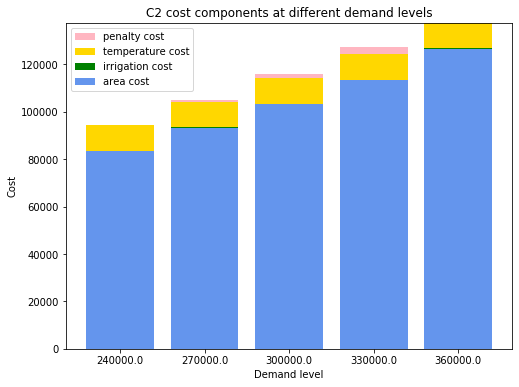

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
demand_level_2 = sen_ana_C2['demand']
penalty_2 = np.array(sen_ana_C2['penalty_cost'])
temperature_2 =np.array(sen_ana_C2['temperature_cost'])
irrigation_2 = np.array(sen_ana_C2['irrigation_cost'])
area_2 = np.array(sen_ana_C2['area_cost'])

ind_2 = [x for x, _ in enumerate(demand_level_2)]

plt.bar(ind_2, penalty_2, width=0.8, label='penalty cost', color='lightpink', bottom=temperature_2+irrigation_2+ area_2)
plt.bar(ind_2, temperature_2, width=0.8, label='temperature cost', color='gold', bottom=irrigation_2+ area_2)
plt.bar(ind_2, irrigation_2, width=0.8, label='irrigation cost', color='green', bottom= area_2)
plt.bar(ind_2, area_2, width=0.8, label='area cost', color='cornflowerblue')

plt.xticks(ind_2, demand_level_2)
plt.ylabel("Cost")
plt.xlabel("Demand level")
plt.legend(loc="upper left")
plt.title("C2 cost components at different demand levels")

plt.show()
fig.savefig('C2 cost components at different demand levels')

## Cycle 3
### Run through 5 scenarios of demand:

In [ ]:
sen_ana_C3 = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6','area','predict_yield','production','penalty_cost','temperature_cost', 'irrigation_cost', 'area_cost', 'total_cost','demand'])
counter = 1
for demand in range (400000, 610000, 50000):
    sen_ana_C3.loc[counter] = cost_optimization(demand,keep_track_C3).loc[1]
    counter = counter + 1
sen_ana_C3

,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost,demand
1,1.0,3.5,426.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,39000.0,10.262726,400246.307373,0.000000,3600.0,171.99,130000.000000,133771.990000,400000.0
2,1.0,3.5,426.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,44000.0,10.262726,451559.936523,0.000000,3600.0,194.04,146666.666667,150460.706667,450000.0
3,1.0,3.5,426.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,49000.0,10.262726,502873.565674,0.000000,3600.0,216.09,163333.333333,167149.423333,500000.0
4,1.0,3.5,426.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,50000.0,10.262726,513136.291504,36863.708496,3600.0,220.50,166666.666667,207350.875163,550000.0
5,1.0,3.5,426.0,21.0,0.0,0.0,1.0,0.0,0.0,0.0,50000.0,10.262726,513136.291504,86863.708496,3600.0,220.50,166666.666667,257350.875163,600000.0


### Plot the cost components corresponding to each scenario of demand:

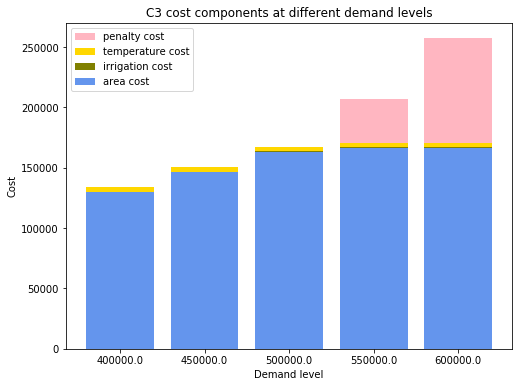

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
demand_level_3 = sen_ana_C3['demand']
penalty_3 = np.array(sen_ana_C3['penalty_cost'])
temperature_3 =np.array(sen_ana_C3['temperature_cost'])
irrigation_3 = np.array(sen_ana_C3['irrigation_cost'])
area_3 = np.array(sen_ana_C3['area_cost'])

ind_3 = [x for x, _ in enumerate(demand_level_3)]

plt.bar(ind_3, penalty_3, width=0.8, label='penalty cost', color='lightpink', bottom=temperature_3+irrigation_3+ area_3)
plt.bar(ind_3, temperature_3, width=0.8, label='temperature cost', color='gold', bottom=irrigation_3+ area_3)
plt.bar(ind_3, irrigation_3, width=0.8, label='irrigation cost', color='olive', bottom= area_3)
plt.bar(ind_3, area_3, width=0.8, label='area cost', color='cornflowerblue')

plt.xticks(ind_3, demand_level_3)
plt.ylabel("Cost")
plt.xlabel("Demand level")
plt.legend(loc="upper left")
plt.title("C3 cost components at different demand levels")

plt.show()
fig.savefig('C3 cost components at different demand levels')

## Cycle 4
### Run through 5 scenarios of demand:

In [ ]:
sen_ana_C4 = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6','area','predict_yield','production','penalty_cost','temperature_cost', 'irrigation_cost', 'area_cost', 'total_cost','demand'])
counter = 1
for demand in range (464000, 697000, 58000):
    sen_ana_C4.loc[counter] = cost_optimization(demand,keep_track_C4).loc[1]
    counter = counter + 1
sen_ana_C4

,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost,demand
1,1.0,3.5,417.0,24.0,0.0,0.0,0.0,1.0,0.0,0.0,43000.0,10.752550,462359.655380,1640.344620,3600.0,189.63,143333.333333,148763.307953,464000.0
2,1.0,3.5,417.0,24.0,0.0,0.0,0.0,1.0,0.0,0.0,49000.0,10.752550,526874.956131,0.000000,3600.0,216.09,163333.333333,167149.423333,522000.0
3,1.0,4.0,417.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,50000.0,11.273432,563671.588898,16328.411102,10800.0,252.00,166666.666667,194047.077769,580000.0
4,1.0,4.0,417.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,50000.0,11.273432,563671.588898,74328.411102,10800.0,252.00,166666.666667,252047.077769,638000.0
5,1.0,4.0,417.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,50000.0,11.273432,563671.588898,132328.411102,10800.0,252.00,166666.666667,310047.077769,696000.0


### Plot the cost components corresponding to each scenario of demand:

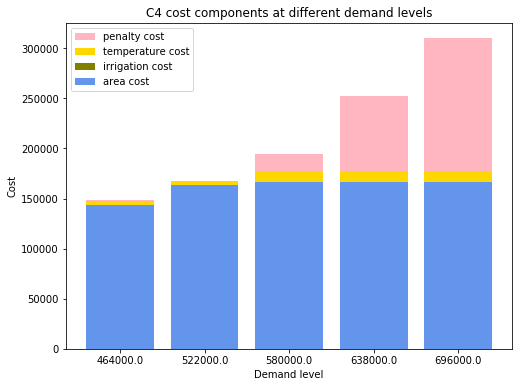

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
demand_level_4 = sen_ana_C4['demand']
penalty_4 = np.array(sen_ana_C4['penalty_cost'])
temperature_4 =np.array(sen_ana_C4['temperature_cost'])
irrigation_4 = np.array(sen_ana_C4['irrigation_cost'])
area_4 = np.array(sen_ana_C4['area_cost'])

ind_4 = [x for x, _ in enumerate(demand_level_4)]

plt.bar(ind_4, penalty_4, width=0.8, label='penalty cost', color='lightpink', bottom=temperature_4+irrigation_4+ area_4)
plt.bar(ind_4, temperature_4, width=0.8, label='temperature cost', color='gold', bottom=irrigation_4+ area_4)
plt.bar(ind_4, irrigation_4, width=0.8, label='irrigation cost', color='olive', bottom= area_4)
plt.bar(ind_4, area_4, width=0.8, label='area cost', color='cornflowerblue')

plt.xticks(ind_4, demand_level_4)
plt.ylabel("Cost")
plt.xlabel("Demand level")
plt.legend(loc="upper left")
plt.title("C4 cost components at different demand levels")

plt.show()
fig.savefig('C4 cost components at different demand levels')

# Additional computations
Here we save the code for additional computations that are used to support our arguments in the Tasks.

## I. Find the optimal level of sun for cycle 4 in Germany
### Main idea:
- In the optimal configuration of cycle 4, we still cannot meet the demand. **One hypothesis: The level of sun in Germany is inadequate.**
- Now we keep the values of the controllable inputs as in the optimal configuration.
- Then run the for loop through different values of sun to find its optimal value.
- The result shows that **the optimal value of sun is 432, higher than actually given in Germany.**
- **In this hypothetical optimal scenario, the company can meet the required demand!**

In [ ]:
# initiate minimum_cost and ideal_input_values dataFrame 
minimum_penalty_cost = 10**9
input_values2 = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6'])
#create dataFrame to keep track all inputs and cost components
keep_track_C4_2 = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6','area','predict_yield','production','penalty_cost','temperature_cost', 'irrigation_cost', 'area_cost', 'total_cost'])
counter = 0

# given optimal inputs of cycle 4, use for loop to run through all values of sun 
area = keep_track_C4.iloc[0, 10]
pesticide = keep_track_C4.iloc[0, 0]
irr_daily = keep_track_C4.iloc[0, 1]
t_in = keep_track_C4.iloc[0, 3]
for sun in range (86, 718,1):    
    
    # predict yield in each scenario
    input_values2.loc[1] = [pesticide, irr_daily, sun, t_in, 0, 0, 0, 1, 0, 0]
    predict_yield = model.predict(input_values2)
    # compute the cost in each scenario 
    if predict_yield[0][0]*area < 580000:
        penalty_cost = (580000-predict_yield[0][0]*area)
    else:
        penalty_cost = 0
    temperature_cost = 3600*abs(t_in-25)
    irrigation_cost = 0.000021*60*irr_daily*area 
    area_cost = 20*area/6      #the cost is on yearly basis so we devide it by 6 for one cycle 
    total_cost = penalty_cost + temperature_cost + irrigation_cost + area_cost
                
    # keep track inputs and costs in all scenarios
    counter = counter + 1
    keep_track_C4_2.loc[counter] = [pesticide, irr_daily, sun, t_in, 0, 0, 0, 1, 0, 0, area, predict_yield[0][0], area*predict_yield[0][0], penalty_cost, temperature_cost, irrigation_cost, area_cost, total_cost]
                
    # find the minimum penalty cost, which means try to reach the demand, regardless of other costs
    if penalty_cost < minimum_penalty_cost:
        minimum_penalty_cost = penalty_cost

# sort the scenarios by the descending order of total_cost                
keep_track_C4_2 = keep_track_C4_2.sort_values(by='total_cost', ascending=True)               
        
# print results
print('The minimum penalty cost is: ', round(minimum_penalty_cost, 2), ' EUR')
print('Optimal input values and resulted cost components are:')
keep_track_C4_2.head(1)

The minimum penalty cost is:  0  EUR
Optimal input values and resulted cost components are:


,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost
347,1.0,4.0,432.0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,50000.0,11.600983,580049.133301,0.0,10800.0,252.0,166666.666667,177718.666667


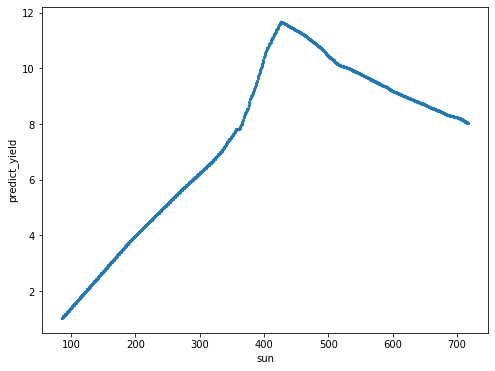

In [ ]:
# scater plot of the relation between sun and yield 
fig, ax = plt.subplots(figsize=(8,6))
keep_track_C4_2.plot.scatter(x='sun', y= 'predict_yield', marker='.', ax=ax)
fig.savefig('sun and predict yield C4 scatterplot')

## II. Change the pesticide in the optimal configuration of cycle 2
### Main idea:
- In task 3, cycle 2 has the second best choice that meets the demand using the pesticide "1".
- Now we test if it can meet the demand with the same optimal input configuration **but using the other pesticide.**
- Result: **It is even worse when using the pesticide "0".**

In [ ]:
#create a input dataframe for yield prediction and a dataframe to keep track all scenarios
input_values_2 = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6'])
keep_track_C2_2 = pd.DataFrame(columns=['pesticide','irrigation','sun','temperature','cycle_C1','cycle_C2','cycle_C3','cycle_C4','cycle_C5','cycle_C6','area','predict_yield','production','penalty_cost','temperature_cost', 'irrigation_cost', 'area_cost', 'total_cost'])
counter = 0

# use for loop to run through all scenarios (pesticide = country in our model)
area = keep_track_C2.iloc[1, 10]
pesticide = 0 #in previous scenario in task 3, the pesticide "1" is used
irr_daily = keep_track_C2.iloc[1, 1]
t_in = keep_track_C2.iloc[1, 3]

# predict yield 
input_values_2.loc[1] = [pesticide, irr_daily, 278.5, float(t_in), 0, 1, 0, 0, 0, 0]
predict_yield = model.predict(input_values_2)
                
# compute the cost in each scenario 
if predict_yield[0][0]*area < 300000:
    penalty_cost = (300000-predict_yield[0][0]*area)
else:
    penalty_cost = 0
temperature_cost = 3600*abs(t_in-15)
irrigation_cost = 0.000021*60*irr_daily*area 
area_cost = 20*area/6      #the cost is on yearly basis so we devide it by 6 for one cycle 
total_cost = penalty_cost + temperature_cost + irrigation_cost + area_cost
                
# keep track inputs and costs in all scenarios
counter = counter + 1
keep_track_C2_2.loc[counter] = [pesticide, irr_daily, 278.5, t_in, 0, 1, 0, 0, 0, 0, area, predict_yield[0][0], area*predict_yield[0][0], penalty_cost, temperature_cost, irrigation_cost, area_cost, total_cost]

# sort the scenarios by the descending order of total_cost                
keep_track_C2_2 = keep_track_C2_2.sort_values(by='total_cost', ascending=True)               

# print results
print('Minimum total cost is: ', round(keep_track_C2_2.iloc[0,17], 2), ' EUR')
print('Optimal input values and resulted cost components are:')
keep_track_C2_2.head(1)

Minimum total cost is:  263572.3  EUR
Optimal input values and resulted cost components are:


,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost
1,0.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,32000.0,4.814239,154055.648804,145944.351196,10800.0,161.28,106666.666667,263572.297863


In [ ]:
# recall: the two best alternatives in cycle 2 use pesticide "1"
keep_track_C2.head(2)

,pesticide,irrigation,sun,temperature,cycle_C1,cycle_C2,cycle_C3,cycle_C4,cycle_C5,cycle_C6,area,predict_yield,production,penalty_cost,temperature_cost,irrigation_cost,area_cost,total_cost
12194,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,31000.0,9.619175,298194.423676,1805.576324,10800.0,156.24,103333.333333,116095.149658
12590,1.0,4.0,278.5,18.0,0.0,1.0,0.0,0.0,0.0,0.0,32000.0,9.619175,307813.598633,0.000000,10800.0,161.28,106666.666667,117627.946667
